In [1]:
import numpy as np
import GPy as gpy
from matplotlib import pyplot as plt

import domain as dom
import function as fun
import utilities as utils

# Dynamical model of an inverted pendulum

In [2]:
# ---------------------------------------------------------------------------*/
# - model an inverted pendulum

# true model parameters of a pendulum system
mass_true = 0.15
friction_true = 0.1
length_true = 0.5
inertia_true = mass_true * length_true ** 2

# wrong model parameters for the pendulum
mass = 0.1 # less mass!!
friction = 0. # no friction!!
length = length_true
gravity = 9.81
inertia = mass * length ** 2

# state saturation
angle_max = np.deg2rad(30)
eigfreq = np.sqrt(gravity/length) # eigen, or natural, frequency
state_max = [angle_max, eigfreq]

# control action saturation, i.e. max torque [m/s^2 * kg * m = kg * m^2 / s^2 = m * N]
torque_max = gravity * mass_true * length_true * np.sin(angle_max)
action_max = torque_max

# instantiate two types of inverted pendulum dynamics, with wrong anf true parameters
dynamics = fun.pendulum_inv(
    mass, length, friction,
    normalization=(state_max, action_max))

dynamics_true = fun.pendulum_inv(
    mass_true, length_true, friction_true,
    normalization=(state_max, action_max))


### Domain discretization

In [3]:
# ---------------------------------------------------------------------------*/
# - discretize a normalized domain

dims_lim = [(-2.0, 2.0), (-1.5, 1.5)]
domain = dom.gridworld(dims_lim, dims_sz=[2001, 1501])

# show domain statistics
print(f'Grid size is {len(domain)}')

tau = np.min(domain.step)
print(f'Discretization step equals {tau:.3f}')

Grid size is 3003501
Discretization step equals 0.002


### Initial optimal policy for a linearized model

In [4]:
# ---------------------------------------------------------------------------*/
# - linearize model dynamics

a, b = dynamics.linearize()

dyn_linear = fun.linear([a, b])
dyn_angle_linear = fun.linear([a[[0], :], b[[0], :]])
dyn_velocity_linear = fun.linear([a[[1], :], b[[1], :]])


# ---------------------------------------------------------------------------*/
# - initial control policy

# lqr cost matrices for state and control,
# which encode how the performance of the angular velocity is
# penalized more, than the angle. Meanwhile, the control cost r is penalized only slightly.
q = 1 * np.diag([1.0, 2.0])
r = 1.2 * np.array([[1.0]])

# compute an optimal policy for the linearized model dynamics
lqr_ctl, lqr_solution = utils.make_dlqr(a, b, q, r)
policy_initial = fun.saturated(fun.linear([-lqr_ctl]), 1.0)

### Definition of stochastic models

In [5]:
# ---------------------------------------------------------------------------*/
# - model uncertainty

ab = np.column_stack((a, b))
ab_true = np.column_stack((dynamics_true.linearize()))

# compute error (variance) between the true and wrong dynamics, and
# clip values that are too small
dyn_error = (ab_true - ab) ** 2
np.clip(dyn_error, 1e-5, None, out=dyn_error)

error_angle = (
    gpy.kern.Linear(dyn_error.shape[1], variances=dyn_error[0, :], ARD=True) +
    gpy.kern.Matern32(1, lengthscale=1, active_dims=[0]) *
    gpy.kern.Linear(1, variances=dyn_error[0, 1]))

error_velocity = (
    gpy.kern.Linear(dyn_error.shape[1], variances=dyn_error[1, :], ARD=True) +
    gpy.kern.Matern32(1, lengthscale=1, active_dims=[0]) *
    gpy.kern.Linear(1, variances=dyn_error[1, 1]))

dyn_angle = fun.dynamics(
    dyn_angle_linear,
    policy=policy_initial,
    error=error_angle)

dyn_velocity = fun.dynamics(
    dyn_velocity_linear,
    policy=policy_initial,
    error=error_velocity)

# stack together stochastic functions, which are scalar, to form a vector-valued function
dyn = fun.stochastic_stacked([dyn_angle, dyn_velocity])

# Dynamic programming

### Configure a dynamic programming problem

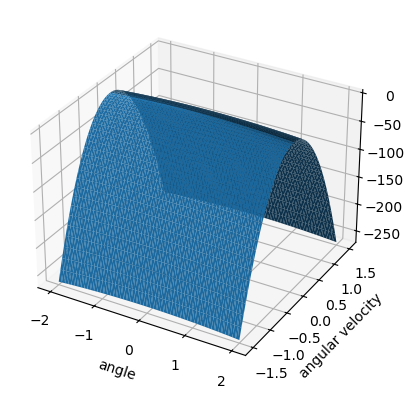

In [6]:
# ---------------------------------------------------------------------------*/
# - initial lyapunov function candidate

# an initial lyapunov function is quadratic and based on the initial optimal policy
lyap_initial = fun.quadratic(lqr_solution)


# ---------------------------------------------------------------------------*/
# - auxiliary domain for value discretization

# to speed up processing time this value function is discretized coarsely
domain_value = dom.gridworld(dims_lim, dims_sz=55)


# ---------------------------------------------------------------------------*/
# - value function approximated using triangulation

# value is initialized with negative values of the initial lyapunov function
value = fun.triangulation(domain_value, -lyap_initial(domain_value.states))

fig, ax = utils.plot3d_triangulation(value)
ax.set_xlabel("angle")
ax.set_ylabel("angular velocity")
plt.show()


# Simulation

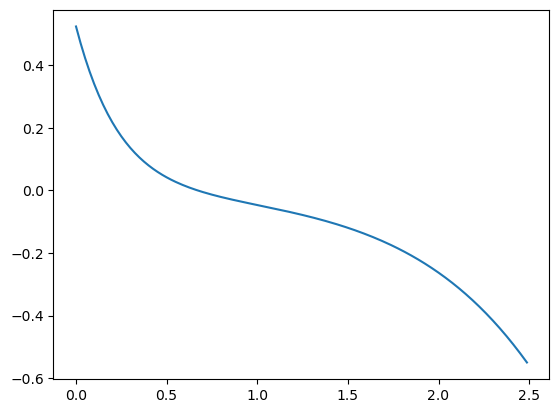

In [7]:
# ---------------------------------------------------------------------------*/
# simulate result and plot

# create a sequence of states for simulation and set the initial state
sim_states = np.zeros((200, 2), dtype=float)
sim_states[0] = [1.0, -0.5] # initial state

# prepare pendulum dynamics for simulation
dynamics_true.timestep = 0.0125
dynamics_true.policy = policy_initial

# simulate
for this in range(len(sim_states) - 1):
    sim_states[this + 1] = dynamics_true(sim_states[this])

time = np.arange(len(sim_states)) * dynamics_true.timestep
data = dynamics_true.denormalize_state(sim_states)

# plot simulated state trajectory
plt.plot(time, data[:, 0])
plt.show()